<a href="https://colab.research.google.com/github/LeticiaFarias21/SAPIENS/blob/main/Sapiens_UFC%2BDepth%2BNormal%2BPart_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14hlK1MWQ-N6YhoE40RRgUjw9Z5PXc4qR)

<img src = https://learnopencv.com/wp-content/uploads/2024/09/Sapiens-Feature-Img-Foundation-for-Human-Vision-Models.gif>

### Installing Dependencies

In [ ]:
!git clone https://github.com/ibaiGorordo/Sapiens-Pytorch-Inference.git

Cloning into 'Sapiens-Pytorch-Inference'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 188 (delta 6), reused 9 (delta 2), pack-reused 169 (from 1)
Receiving objects: 100% (188/188), 48.73 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
%cd Sapiens-Pytorch-Inference

/content/Sapiens-Pytorch-Inference


In [ ]:
!pip install -r requirements.txt -q
!pip install gdown

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.7 MB/s eta 0:00:00


In [ ]:
!pwd

/content/Sapiens-Pytorch-Inference


In [ ]:
import os
import sys
import shutil
from typing import List
import requests
from tqdm import tqdm
from datetime import timedelta

from enum import Enum
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imread_from_url import imread_from_url

from dataclasses import dataclass
from torchvision import transforms
import torch
import torch.nn.functional as F

from huggingface_hub import hf_hub_download, hf_hub_url


### Download Test Images

In [ ]:
import os
import gdown
os.makedirs("test_images/", exist_ok = True)

gdown.download('https://drive.google.com/uc?id=1BAbhNFKNE0mHpxxb4ma1SiNKvErSD9wn','test_images/ufc_kick.mp4', quiet=False)
gdown.download('https://drive.google.com/uc?id=1MkxbGNzFAsgL8zPqRypl5b-KJzD4_Erv','test_images/fight.png', quiet=False)
gdown.download('https://drive.google.com/uc?id=1v74n_0C3Vi4-FqNYDA6pnGSnrtw50Zsf','test_images/fight480p.mov', quiet=False)
gdown.download('https://drive.google.com/uc?id=1oXDc1b_ck3UpNfLYMxkOKei2KpP6Ag96', 'test_images/longFight480p.mov', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1BAbhNFKNE0mHpxxb4ma1SiNKvErSD9wn
To: /content/Sapiens-Pytorch-Inference/test_images/ufc_kick.mp4
100%|██████████| 10.4M/10.4M [00:00<00:00, 71.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MkxbGNzFAsgL8zPqRypl5b-KJzD4_Erv
To: /content/Sapiens-Pytorch-Inference/test_images/fight.png
100%|██████████| 652k/652k [00:00<00:00, 74.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v74n_0C3Vi4-FqNYDA6pnGSnrtw50Zsf
To: /content/Sapiens-Pytorch-Inference/test_images/fight480p.mov
100%|██████████| 1.33M/1.33M [00:00<00:00, 49.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oXDc1b_ck3UpNfLYMxkOKei2KpP6Ag96
To: /content/Sapiens-Pytorch-Inference/test_images/longFight480p.mov
100%|██████████| 89.7M/89.7M [00:01<00:00, 67.8MB/s]


'test_images/longFight480p.mov'

### Download Sapiens-1B Model for all tasks

In [ ]:
!wget -nc https://huggingface.co/facebook/sapiens-normal-1b-torchscript/resolve/main/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2  -O models/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-seg-1b-torchscript/resolve/main/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2 -O models/sapiens_1b_goliath_best_goliath_mIoU_7994_epoch_151_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-depth-1b-torchscript/resolve/main/sapiens_1b_render_people_epoch_88_torchscript.pt2 -O models/sapiens_1b_render_people_epoch_88_torchscript.pt2

!wget -nc https://huggingface.co/facebook/sapiens-pose-1b-torchscript/resolve/main/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2 -O models/sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2

--2024-11-22 17:47:51--  https://huggingface.co/facebook/sapiens-normal-1b-torchscript/resolve/main/sapiens_1b_normal_render_people_epoch_115_torchscript.pt2
Resolving huggingface.co (huggingface.co)... 3.171.171.65, 3.171.171.128, 3.171.171.6, ...
Connecting to huggingface.co (huggingface.co)|3.171.171.65|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/16/3e/163ec28269ad2e6897e2dd1ada8f1ce2f1a85d0e85f5c9f9572b924fd25e0aeb/00e29d62c385de04f40bc188dd4571e19cab26a8dbc1424d61a77206b3758fb2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sapiens_1b_normal_render_people_epoch_115_torchscript.pt2%3B+filename%3D%22sapiens_1b_normal_render_people_epoch_115_torchscript.pt2%22%3B&Expires=1732556871&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjU1Njg3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzE2LzNlLzE2M2VjMjgyNjlhZDJlNjg5N2UyZGQxYWRhOGYxY2UyZjFhODVkM

### Common Utilities

In [ ]:
class TaskType(Enum):
    DEPTH = "depth"
    NORMAL = "normal"
    SEG = "seg"
    POSE = "pose"


def download(url: str, filename: str):
    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
            }
            with tqdm(**tqdm_params) as pb:
                for chunk in r.iter_content(chunk_size=8192):
                    pb.update(len(chunk))
                    f.write(chunk)


def download_hf_model(model_name: str, task_type: TaskType, model_dir: str = 'models'):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    path = model_dir + "/" + model_name
    if os.path.exists(path):
        return path

    print(f"Model {model_name} not found, downloading from Hugging Face Hub...")

    model_version = "_".join(model_name.split("_")[:2])
    repo_id = "facebook/sapiens"
    subdirectory = f"sapiens_lite_host/torchscript/{task_type.value}/checkpoints/{model_version}"

    # hf_hub_download(repo_id=repo_id, filename=model_name, subfolder=subdirectory, local_dir=model_dir)
    url = hf_hub_url(repo_id=repo_id, filename=model_name, subfolder=subdirectory)
    download(url, path)
    print("Model downloaded successfully to", path)

    return path


def create_preprocessor(input_size: tuple[int, int],
                        mean: List[float] = (0.485, 0.456, 0.406),
                        std: List[float] = (0.229, 0.224, 0.225)):
    return transforms.Compose([transforms.ToPILImage(),
                               transforms.Resize(input_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std),
                               transforms.Lambda(lambda x: x.unsqueeze(0))
                               ])


### Pose Estimation

In [ ]:
from ultralytics import YOLO

@dataclass
class DetectorConfig:
    model_path: str = "models/yolov8m.pt"
    person_id: int = 0
    conf_thres: float = 0.25


def draw_boxes(img, boxes, color=(0, 255, 0), thickness=2):
    draw_img = img.copy()
    for box in boxes:
        x1, y1, x2, y2 = box
        draw_img = cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thickness)
    return draw_img


class Detector:
    def __init__(self, config: DetectorConfig = DetectorConfig()):
        model_path = config.model_path
        if not model_path.endswith(".pt"):
            model_path = model_path.split(".")[0] + ".pt"
        self.model = YOLO(model_path)
        self.person_id = config.person_id
        self.conf_thres = config.conf_thres

    def __call__(self, img: np.ndarray) -> np.ndarray:
        return self.detect(img)

    def detect(self, img: np.ndarray) -> np.ndarray:
        start = time.perf_counter()
        results = self.model(img, conf=self.conf_thres)
        detections = results[0].boxes.data.cpu().numpy()  # (x1, y1, x2, y2, conf, cls)

        # Filter out only person
        person_detections = detections[detections[:, -1] == self.person_id]
        boxes = person_detections[:, :-2].astype(int)

        print(f"Detection inference took: {time.perf_counter() - start:.4f} seconds")
        return boxes


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!wget https://huggingface.co/spaces/facebook/sapiens-pose/resolve/main/classes_and_palettes.py -O classes_and_palettes.py

--2024-11-22 17:53:29--  https://huggingface.co/spaces/facebook/sapiens-pose/resolve/main/classes_and_palettes.py
Resolving huggingface.co (huggingface.co)... 3.171.171.128, 3.171.171.6, 3.171.171.65, ...
Connecting to huggingface.co (huggingface.co)|3.171.171.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40865 (40K) [text/plain]
Saving to: ‘classes_and_palettes.py’

classes_and_palette 100%[===================>]  39.91K  --.-KB/s    in 0.01s   

2024-11-22 17:53:29 (3.65 MB/s) - ‘classes_and_palettes.py’ saved [40865/40865]



In [ ]:
from sapiens_inference.pose_classes_and_palettes import (
    COCO_KPTS_COLORS,
    COCO_WHOLEBODY_KPTS_COLORS,
    GOLIATH_KPTS_COLORS,
    GOLIATH_SKELETON_INFO,
    GOLIATH_KEYPOINTS
)

class SapiensPoseEstimationType(Enum):
    POSE_ESTIMATION_1B = "sapiens_1b_goliath_best_goliath_AP_640_torchscript.pt2"



In [ ]:
class SapiensPoseEstimation:
    def __init__(self,
                 type: SapiensPoseEstimationType = SapiensPoseEstimationType.POSE_ESTIMATION_1B,
                 device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 dtype: torch.dtype = torch.float32):
        # Load the model
        self.device = device
        self.dtype = dtype
        path = download_hf_model(type.value, TaskType.POSE)
        self.model = torch.jit.load(path).eval().to(device).to(dtype)
        self.preprocessor = transforms.Compose([transforms.ToPILImage(),
                               transforms.Resize((1024,768)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std),
                               ])

        # Initialize the YOLO-based detector
        self.detector = Detector()



    def __call__(self, img: np.ndarray) -> np.ndarray:
        start = time.perf_counter()

        # Detect persons in the image
        bboxes = self.detector.detect(img)

        # Process the image and estimate the pose
        pose_result_image, keypoints = self.estimate_pose(img, bboxes)

        print(f"Pose estimation inference took: {time.perf_counter() - start:.4f} seconds")
        return pose_result_image, keypoints


    @torch.inference_mode()
    def estimate_pose(self, img: np.ndarray, bboxes: List[List[float]]) -> (np.ndarray, List[dict]):
        all_keypoints = []
        result_img = img.copy()

        for bbox in bboxes:
            cropped_img = self.crop_image(img, bbox)
            tensor = self.preprocessor(cropped_img).unsqueeze(0).to(self.device).to(self.dtype)

            heatmaps = self.model(tensor)
            keypoints = self.heatmaps_to_keypoints(heatmaps[0].cpu().numpy())
            all_keypoints.append(keypoints)

            # Draw the keypoints on the original image
            result_img = self.draw_keypoints(result_img, keypoints, bbox)

        return result_img, all_keypoints

    def crop_image(self, img: np.ndarray, bbox: List[float]) -> np.ndarray:
        x1, y1, x2, y2 = map(int, bbox[:4])
        return img[y1:y2, x1:x2]


    def heatmaps_to_keypoints(self, heatmaps: np.ndarray) -> dict:
        keypoints = {}
        for i, name in enumerate(GOLIATH_KEYPOINTS):
            if i < heatmaps.shape[0]:
                y, x = np.unravel_index(np.argmax(heatmaps[i]), heatmaps[i].shape)
                conf = heatmaps[i, y, x]
                keypoints[name] = (float(x), float(y), float(conf))
        return keypoints



    def draw_keypoints(self, img: np.ndarray, keypoints: dict, bbox: List[float]) -> np.ndarray:
        x1, y1, x2, y2 = map(int, bbox[:4])
        bbox_width, bbox_height = x2 - x1, y2 - y1
        img_copy = img.copy()

        # Draw keypoints on the image
        for i, (name, (x, y, conf)) in enumerate(keypoints.items()):
            if conf > 0.3:  # Only draw confident keypoints
                x_coord = int(x * bbox_width / 192) + x1
                y_coord = int(y * bbox_height / 256) + y1
                cv2.circle(img_copy, (x_coord, y_coord), 3, GOLIATH_KPTS_COLORS[i], -1)

        # Optionally draw skeleton
        for _, link_info in GOLIATH_SKELETON_INFO.items():
            pt1_name, pt2_name = link_info['link']
            if pt1_name in keypoints and pt2_name in keypoints:
                pt1 = keypoints[pt1_name]
                pt2 = keypoints[pt2_name]
                if pt1[2] > 0.3 and pt2[2] > 0.3:
                    x1_coord = int(pt1[0] * bbox_width / 192) + x1
                    y1_coord = int(pt1[1] * bbox_height / 256) + y1
                    x2_coord = int(pt2[0] * bbox_width / 192) + x1
                    y2_coord = int(pt2[1] * bbox_height / 256) + y1
                    cv2.line(img_copy, (x1_coord, y1_coord), (x2_coord, y2_coord), GOLIATH_KPTS_COLORS[i], 2)

        return img_copy


Model sapiens_0.3b_goliath_best_goliath_AP_573_torchscript.pt2 not found, downloading from Hugging Face Hub...


100%|██████████| 1.23G/1.23G [00:31<00:00, 42.3MB/s]


Model downloaded successfully to models/sapiens_0.3b_goliath_best_goliath_AP_573_torchscript.pt2


100%|██████████| 49.7M/49.7M [00:00<00:00, 201MB/s]



0: 480x640 2 persons, 1794.0ms
Speed: 30.1ms preprocess, 1794.0ms inference, 34.6ms postprocess per image at shape (1, 3, 480, 640)
Detection inference took: 4.3595 seconds
Pose estimation inference took: 174.7827 seconds
Time taken: 174.7888 seconds


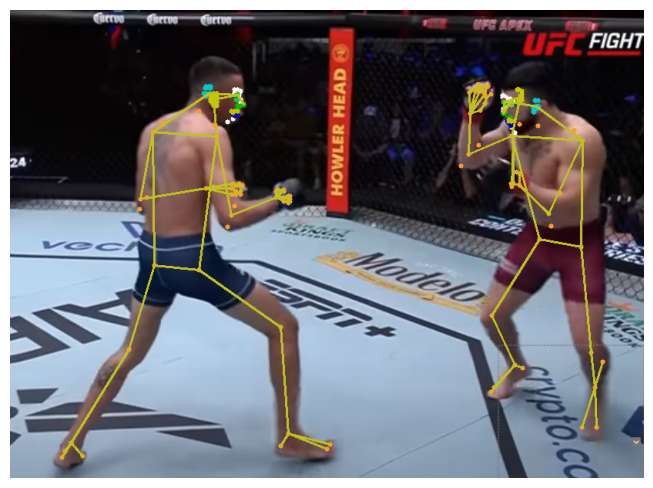

In [ ]:
from sapiens_inference.pose import SapiensPoseEstimation

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pose_estimator = SapiensPoseEstimation()

    img_path = "test_images/fight.png"
    img = cv2.imread(img_path)

    # Perform pose estimation
    start_time = time.perf_counter()
    result_img, keypoints = pose_estimator(img)

    height, width, _ = result_img.shape

    fig = plt.figure(figsize = (width/100, height/100), dpi=100)

    print(f"Time taken: {time.perf_counter() - start_time:.4f} seconds")

    result_img_rgb = result_img[:,:,::-1]

    plt.imshow(result_img_rgb)
    plt.axis('off')

    plt.savefig("pose_output_rgb.png", bbox_inches='tight', pad_inches=0)
    plt.show()

del pose_estimator
torch.cuda.empty_cache()

In [ ]:
import cv2
import torch
import time
import matplotlib.pyplot as plt
from sapiens_inference.pose import SapiensPoseEstimation

def process_frame(frame, pose_estimator):
    """
    Process a single frame to estimate pose and return the processed frame.
    """
    result_img, _ = pose_estimator(frame)  # Pose estimation
    result_img_rgb = result_img[:, :, ::-1]  # Convert BGR to RGB for saving/display
    return result_img_rgb

def process_video(input_video_path, output_video_path):
    """
    Process a video frame by frame for pose estimation and save the result as a new video.
    """
    # Load the video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Initialize pose estimator
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pose_estimator = SapiensPoseEstimation()

    frame_idx = 0
    while True:
        ret, frame = cap.read()  # Read next frame
        if not ret:
            break  # Exit when no more frames are available

        start_time = time.perf_counter()
        processed_frame = process_frame(frame, pose_estimator)
        print(f"Processed frame {frame_idx + 1}/{total_frames} in {time.perf_counter() - start_time:.4f} seconds")

        # Convert RGB to BGR for OpenCV and write to output video
        processed_frame_bgr = processed_frame[:, :, ::-1]
        out.write(processed_frame_bgr)

        frame_idx += 1

    # Release resources
    cap.release()
    out.release()
    del pose_estimator
    torch.cuda.empty_cache()
    print("Video processing complete.")

def download_file(file_path):
    """
    Make the processed video available for download.
    """
    from IPython.display import HTML
    import base64

    with open(file_path, "rb") as f:
        data = f.read()
    b64 = base64.b64encode(data).decode()
    href = f'<a href="data:video/mp4;base64,{b64}" download="processed_video.mp4">Download Processed Video</a>'
    return HTML(href)

if __name__ == "__main__":
    input_video_path = "test_images/longFight480p.mov"  # Replace with your input video path
    output_video_path = "test_images/longFight480p_proscessed.mov"  # Replace with your desired output video path
    process_video(input_video_path, output_video_path)

    # For download (useful in Jupyter or Colab environments)
    try:
        from IPython.display import display
        display(download_file(output_video_path))
    except ImportError:
        print(f"Processed video is available at {output_video_path}")


0: 384x640 11 persons, 945.6ms
Speed: 2.3ms preprocess, 945.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Detection inference took: 1.5109 seconds
Pose estimation inference took: 885.7214 seconds
Processed frame 1/11040 in 885.7239 seconds

0: 384x640 10 persons, 1061.6ms
Speed: 6.0ms preprocess, 1061.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Detection inference took: 1.0826 seconds
Pose estimation inference took: 808.8322 seconds
Processed frame 2/11040 in 808.8329 seconds

0: 384x640 11 persons, 1456.0ms
Speed: 2.6ms preprocess, 1456.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Detection inference took: 1.4763 seconds
Pose estimation inference took: 887.8723 seconds
Processed frame 3/11040 in 887.8731 seconds

0: 384x640 10 persons, 1011.8ms
Speed: 6.5ms preprocess, 1011.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Detection inference took: 1.0329 seconds
Pose estimation inference took: